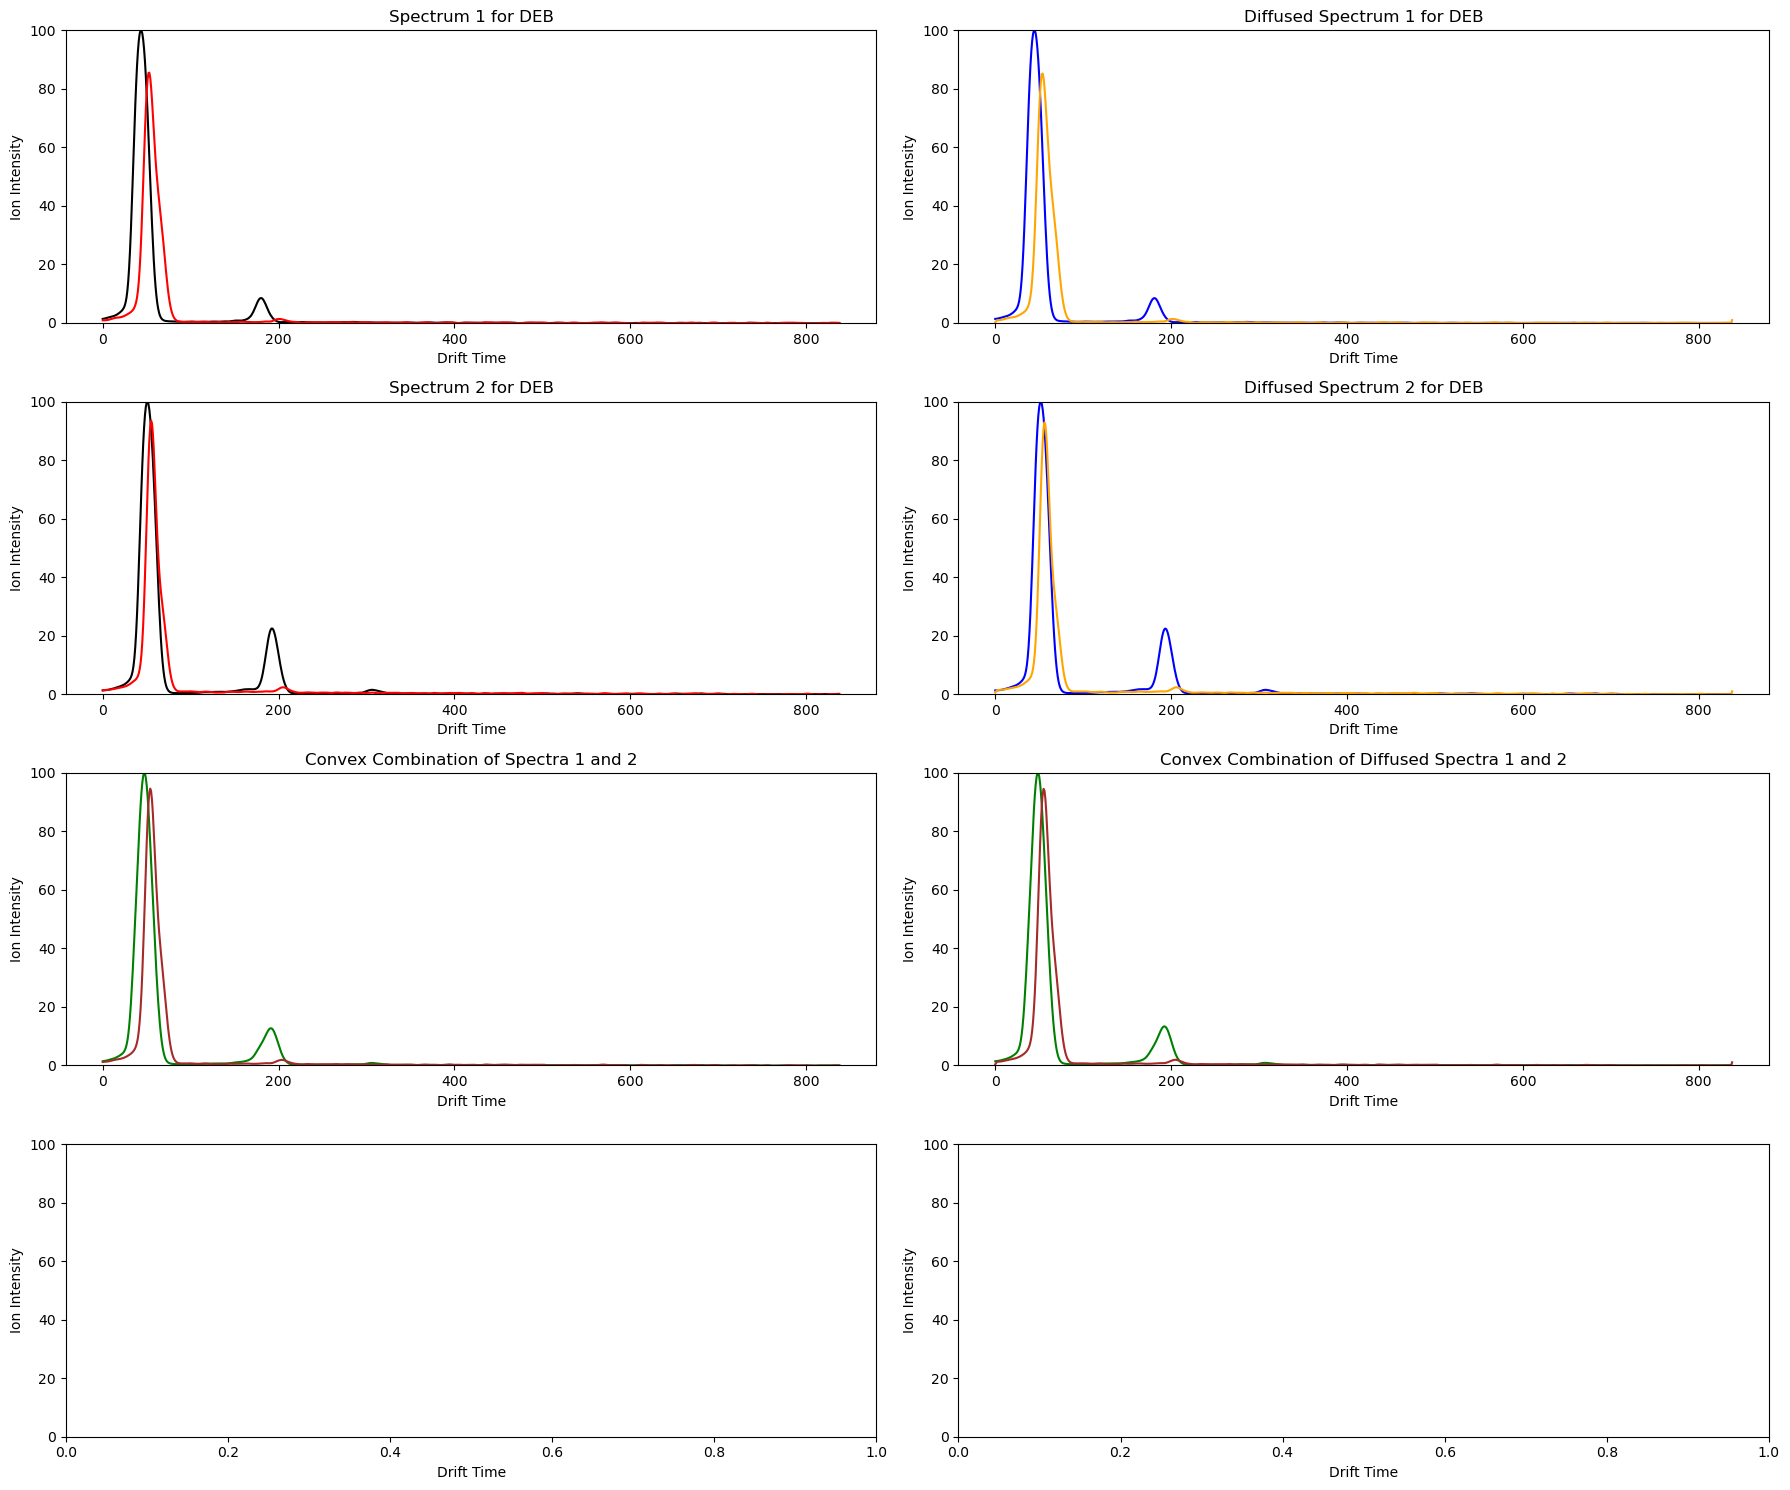

In [12]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from iterativenn.iterativenn.src.iterativenn.nn_modules.MaskedLinear import MaskedLinear

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def add_noise(dataframe, n=1):
    labels = dataframe.iloc[:, -label_size:]
    chemicals = dataframe.iloc[:, :-label_size]
    all_blurred_chemicals = []
    blur_counts = []

    for _ in range(n):
        blurred_chemicals = chemicals.rolling(window=3, min_periods=1, axis=1).mean().values
        blurred_chemicals = np.clip(blurred_chemicals, 0, None)
        max_entry = np.max(blurred_chemicals)
        if max_entry > 0:
            blurred_chemicals = (blurred_chemicals / max_entry) * 100
        all_blurred_chemicals.append(blurred_chemicals)
        blur_counts.extend([_ + 1] * len(chemicals))

    blurred_chemicals_combined = np.vstack(all_blurred_chemicals)
    blurred_labels_combined = np.vstack([labels.values] * n)
    blur_counts_column = np.array(blur_counts).reshape(-1, 1)
    
    combined_df = pd.concat([pd.DataFrame(blurred_chemicals_combined), pd.DataFrame(blurred_labels_combined), pd.DataFrame(blur_counts_column, columns=['Blur_Count'])], axis=1, ignore_index=True)
    combined_df.columns = [f'col_{i}' for i in range(combined_df.shape[1])]
    return combined_df

def plot_mass_spectra_with_noise_and_network(label_idx, x_target_tensor, chem_INN, add_noise):
    """
    Plots and processes mass spectra with noise and network mapping.
    
    Args:
        label_idx (int): The label index (0 to 49).
        x_target_tensor (torch.Tensor): Tensor containing target data with labels.
        chem_INN (torch.nn.Module): Neural network model for chemical data processing.
        add_noise (callable): Function to add noise to a spectrum.
    """
    num_features = data_size  # Number of mass spectra columns

    # Extract the first and second entries with the provided label
    label_mask = (x_target_tensor[:, -label_size + label_idx] == 1)
    label_indices = torch.where(label_mask)[0][:2]

    if len(label_indices) < 2:
        raise ValueError("Not enough instances of the label to perform the required operations.")

    spectrum1 = x_target_tensor[label_indices[0], :].cpu()
    spectrum2 = x_target_tensor[label_indices[1], :].cpu()
    
    max_entry = torch.max(spectrum1)
    if max_entry > 0:  # Avoid division by zero
        scaled_spectrum1 = (spectrum1 / max_entry) * 100

    max_entry = torch.max(spectrum2)
    if max_entry > 0:  # Avoid division by zero
        scaled_spectrum2 = (spectrum2 / max_entry) * 100
    
    # Add noise to the entire spectrum (including last 50 dimensions)
    spectrum1_df = pd.DataFrame(spectrum1.clone().unsqueeze(0).numpy())
    spectrum2_df = pd.DataFrame(spectrum2.clone().unsqueeze(0).numpy())

    noisy_spectrum1_df = add_noise(spectrum1_df, 1)
    noisy_spectrum2_df = add_noise(spectrum2_df, 1)

    # Convert noisy spectra back to tensors
    noisy_spectrum1 = torch.tensor(noisy_spectrum1_df.values).squeeze(0)
    noisy_spectrum2 = torch.tensor(noisy_spectrum2_df.values).squeeze(0)
    
    max_entry = torch.max(noisy_spectrum1)
    if max_entry > 0:  # Avoid division by zero
        scaled_noisy_spectrum1 = (noisy_spectrum1 / max_entry) * 100

    max_entry = torch.max(noisy_spectrum2)
    if max_entry > 0:  # Avoid division by zero
        scaled_noisy_spectrum2 = (noisy_spectrum2 / max_entry) * 100

    # Convex combinations (retain the last 50 dimensions)
    alpha = 0.5
    convex_original = alpha * spectrum1 + (1 - alpha) * spectrum2
    convex_noisy = alpha * noisy_spectrum1 + (1 - alpha) * noisy_spectrum2

    # Ensure convex combinations are on the same device and dtype as the model
    convex_original = convex_original.to(device).to(torch.float32)
    convex_noisy = convex_noisy.to(device).to(torch.float32)
    
    max_entry = torch.max(convex_original)
    if max_entry > 0:  # Avoid division by zero
        scaled_convex_original = (convex_original / max_entry) * 100

    max_entry = torch.max(convex_noisy)
    if max_entry > 0:  # Avoid division by zero
        scaled_convex_noisy = (convex_noisy / max_entry) * 100

    # Pass through the network 5 times
    chem_INN.eval()
    with torch.no_grad():
        # Initialize outputs on the correct device and dtype
        outputs_original = [convex_original.unsqueeze(0).to(device).to(torch.float32)]
        outputs_original[-1] = torch.cat([outputs_original[-1], torch.zeros(outputs_original[-1].size(0), 1, device=outputs_original[-1].device)], dim=1)
        outputs_noisy = [convex_noisy.unsqueeze(0).to(device).to(torch.float32)]
        
        for _ in range(5):
            # Append network outputs to the respective lists
            outputs_original.append(chem_INN(outputs_original[-1]))
            outputs_noisy.append(chem_INN(outputs_noisy[-1]))

    # Normalize only the final outputs
    final_original = outputs_original[-1]
    max_entry = torch.max(final_original)
    if max_entry > 0:  # Avoid division by zero
        final_original = (final_original / max_entry) * 100

    final_noisy = outputs_noisy[-1]
    max_entry = torch.max(final_noisy)
    if max_entry > 0:  # Avoid division by zero
        final_noisy = (final_noisy / max_entry) * 100
    
    # Graphing
    fig, axes = plt.subplots(4, 2, figsize=(18, 15))
    axes = axes.flatten()

    # Original spectra
    axes[0].plot(scaled_spectrum1[:num_features//2].numpy(), label="Spectrum 1 (Original, Positive)", color="black")
    axes[0].plot(scaled_spectrum1[num_features//2:num_features].numpy(), label="Spectrum 1 (Original, Negative)", color="red")
    axes[0].set_title("Spectrum 1 for DEB")
    axes[2].plot(scaled_spectrum2[:num_features//2].numpy(), label="Spectrum 2 (Original, Positive)", color="black")
    axes[2].plot(scaled_spectrum2[num_features//2:num_features].numpy(), label="Spectrum 2 (Original, Negative)", color="red")
    axes[2].set_title("Spectrum 2 for DEB")

    # Noisy spectra
    axes[1].plot(scaled_noisy_spectrum1[:num_features//2].numpy(), label="Spectrum 1 (Noisy, Positive)", color="blue")
    axes[1].plot(scaled_noisy_spectrum1[num_features//2:num_features].numpy(), label="Spectrum 1 (Noisy, Negative)", color="orange")
    axes[1].set_title("Diffused Spectrum 1 for DEB")
    axes[3].plot(scaled_noisy_spectrum2[:num_features//2].numpy(), label="Spectrum 2 (Noisy, Positive)", color="blue")
    axes[3].plot(scaled_noisy_spectrum2[num_features//2:num_features].numpy(), label="Spectrum 2 (Noisy, Negative)", color="orange")
    axes[3].set_title("Diffused Spectrum 2 for DEB")

    # Convex combinations
    axes[4].plot(scaled_convex_original[:num_features//2].cpu().numpy(), label="Convex Combination (Original, Positive)", color="green")
    axes[4].plot(scaled_convex_original[num_features//2:num_features].cpu().numpy(), label="Convex Combination (Original, Negative)", color="brown")
    axes[4].set_title("Convex Combination of Spectra 1 and 2")
    axes[5].plot(scaled_convex_noisy[:num_features//2].cpu().numpy(), label="Convex Combination (Noisy, Positive)", color="green")
    axes[5].plot(scaled_convex_noisy[num_features//2:num_features].cpu().numpy(), label="Convex Combination (Noisy, Negative)", color="brown")
    axes[5].set_title("Convex Combination of Diffused Spectra 1 and 2")

    # Network outputs (final iteration)
    #axes[6].plot(final_original[0, :num_features//2].cpu().numpy(), label="Final Output (Original, Positive)", color="purple")
    #axes[6].plot(final_original[0, num_features//2:num_features].cpu().numpy(), label="Final Output (Original, Negative)", color="pink")
    #axes[6].set_title("Convex Combination of Spectra 1 and 2 - After Chem_INN")
    #axes[7].plot(final_noisy[0, :num_features//2].cpu().numpy(), label="Final Output (Noisy, Positive)", color="purple")
    #axes[7].plot(final_noisy[0, num_features//2:num_features].cpu().numpy(), label="Final Output (Noisy, Negative)", color="pink")
    #axes[7].set_title("Convex Combination Diffused of Spectra 1 and 2 - After Chem_INN")

    # Legend and axis scaling
    for ax in axes:
        ax.set_xlabel("Drift Time")
        ax.set_ylabel("Ion Intensity")
        ax.set_ylim(0, 100)

    # Remove unused axes
    #fig.delaxes(axes[8])
    plt.tight_layout()
    plt.show()
    
def initialize_masked_linear():
    row_sizes = [data_size-1, label_size, 1]
    col_sizes = [data_size+label_size]
    block_types = [['R=0.1'], ['R=0.1'], ['W']]
    initialization_types = [[1], ['G'], ['G']]
    trainable = [[1], [1], [1]]
    chem_ml = MaskedLinear(train_shape+1, train_shape+1, bias=True)
    return chem_ml.from_description(row_sizes=row_sizes, col_sizes=col_sizes, block_types=block_types, initialization_types=initialization_types, trainable=trainable)

x_train = pd.read_feather('/home/kjmetzler/train_data_subset.feather')
x_train.drop(columns=['Unnamed: 0', 'index', 'Label'], inplace=True)
x_train = torch.tensor(x_train.values).to(device)
label_size = 8
data_size = x_train.shape[1] - label_size + 1
train_shape = data_size + label_size + 1

chem_MaskLin = initialize_masked_linear()
chem_INN = torch.nn.Sequential(chem_MaskLin, torch.nn.LeakyReLU(0.1)).to(device)

model = chem_INN
model.load_state_dict(torch.load('/home/kjmetzler/trained_model.pth'))
model.eval()

plot_mass_spectra_with_noise_and_network(0, x_train, chem_INN, add_noise)


In [5]:
x_train = pd.read_feather('/home/kjmetzler/train_data_subset.feather')
x_train.drop(columns=['Unnamed: 0', 'index', 'Label'], inplace=True)

print(x_train.head())

   p_184  p_185  p_186  p_187  p_188  p_189  p_190  p_191  p_192  p_193  ...  \
0   73.0   77.0   79.0   82.0   83.0   85.0   86.0   88.0   91.0   93.0  ...   
1   87.0   89.0   92.0   94.0   96.0   98.0  101.0  102.0  105.0  109.0  ...   
2   60.0   63.0   64.0   66.0   68.0   70.0   73.0   75.0   77.0   78.0  ...   
3   67.0   69.0   72.0   77.0   79.0   84.0   88.0   91.0   96.0  100.0  ...   
4   81.0   83.0   86.0   86.0   89.0   91.0   93.0   97.0  101.0  106.0  ...   

   n_1020  n_1021  DEB  DEM  DMMP  DPM  DtBP  JP8  MES  TEPO  
0   -12.0   -14.0  0.0  0.0   0.0  0.0   0.0  0.0  0.0   1.0  
1     5.0     5.0  0.0  0.0   0.0  0.0   0.0  0.0  0.0   1.0  
2     2.0     0.0  0.0  0.0   0.0  0.0   0.0  0.0  0.0   1.0  
3   -15.0   -13.0  0.0  0.0   0.0  0.0   0.0  0.0  0.0   1.0  
4   -11.0   -11.0  0.0  0.0   0.0  0.0   0.0  0.0  0.0   1.0  

[5 rows x 1684 columns]


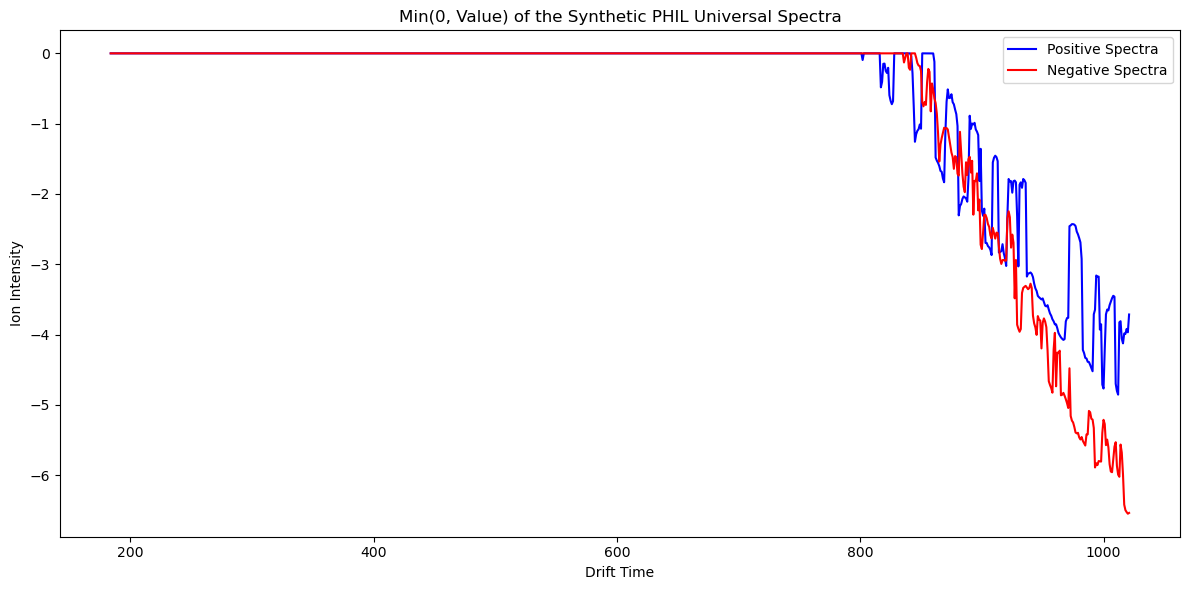

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the feather file
synthetic_test_spectra = pd.read_feather('/home/kjmetzler/scratch/PHIL/universal_generator/_synthetic_test_spectra.feather')
synthetic_test_spectra.drop(columns=['index', 'Label'], inplace=True)

# Extract the first row and apply the condition (min of value and 0)
first_row = synthetic_test_spectra.iloc[0].clip(upper=0)
# Split the first row into two parts: columns starting with 'p' and 'n'
p_columns = first_row[first_row.index.str.startswith('p')]
n_columns = first_row[first_row.index.str.startswith('n')]

# Extract the numeric part of the column names for x-axis
p_x = p_columns.index.str.extract(r'(\d+)$').astype(int).squeeze()
n_x = n_columns.index.str.extract(r'(\d+)$').astype(int).squeeze()

# Plot the two parts in the same graph
plt.figure(figsize=(12, 6))
plt.plot(p_x, p_columns, label="Positive Spectra", color='blue')
plt.plot(n_x, n_columns, label="Negative Spectra", color='red')

plt.title("Min(0, Value) of the Synthetic PHIL Universal Spectra")
plt.xlabel("Drift Time")
plt.ylabel("Ion Intensity")
plt.legend()
plt.tight_layout()
plt.show()
